<img src="mioti.png" style="height: 100px">
<center style="color:#888">Módulo Data Science in IoT<br/>Asignatura: Machine learning 2: Unsupervised learning</center>
# Challenge S5: Clusterización II

## Plan de expansión: apertura de nuevas tiendas

Una cadena de supermercados desea identificar áreas en las que abrir nuevos centros.

Utilizando información censal (tabla CENSUS2000) el objetivo es encontrar áreas cuyos perfiles de clientes se adapten a diferentes tipologías de centros: boutiques, supermercados de presupuesto medio, grandes superficies, etc.

Se supone que el país tiene una densidad muy baja de establecimientos comerciales y se puede seguir abriendo tiendas en las diferentes regiones.

<img src="tienda.jpg">

## Configuración del entorno

Es recomendable declarar en un bloque al inicio todos los paquetes que vas a utilizar en este notebook:

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

### Información del dataset Census2000
Como hemos mencionado, vamos a hacer uso de un dataset con información censal (tabla CENSUS2000).

Las variables de las que dispone son:  

* Numrow: Numero de fila
* ID: Identificador del registro
* LocX y LocY para geolocalizar las zonas
* RegDens: Densidad de población de la región
* RegPop: Número de habitantes de la región
* MedHHInc: Nivel de ingresos medio de la unidad familiar
* MeanHHSz: Tamaño medio de la unidad familiar (HH = Household)

Los datos se encuentran en un fichero `csv` llamado `census2000.csv`.

Carga los datos en un dataframe para hacer los ejercicios de este bloque.

In [2]:
dfc=pd.read_csv("census2000.csv")

Una vez cargados los datos debemos inspeccionarlos antes de empezar nuestro análisis.

In [3]:
dfc.head()

,Numrow,ID,LocX,LocY,RegDens,RegPop,MedHHInc,MeanHHSz
0,0,00601,-66.749472,18.180103,70.0,19143.0,9888.0,3.24
1,1,00602,-67.180247,18.363285,83.0,42042.0,11384.0,3.10
2,2,00603,-67.134224,18.448619,86.0,55592.0,10748.0,2.84
3,3,00604,-67.136995,18.498987,83.0,3844.0,31199.0,3.00
4,4,00606,-66.958807,18.182151,65.0,6449.0,9243.0,3.20


¿Cuantos registros y columnas tiene el dataset?

¿De que tipo son los datos cargados?

In [4]:
dfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33178 entries, 0 to 33177
Data columns (total 8 columns):
Numrow      33178 non-null int64
ID          33178 non-null object
LocX        33178 non-null float64
LocY        33178 non-null float64
RegDens     32165 non-null float64
RegPop      33178 non-null float64
MedHHInc    33178 non-null float64
MeanHHSz    33178 non-null float64
dtypes: float64(6), int64(1), object(1)
memory usage: 2.0+ MB


## Filtrado de datos
Una particularidad de este dataset es que contiene información sobre hogares que no tiene miembros en la unidad familiar. Cuantos registros se tienen con unidades familiares iguales o superiores a 1?:

In [5]:
dfc_filter = dfc[dfc['MeanHHSz'] >= 1]
len(dfc_filter)

32079

En este caso vamos a trabajar sólo con aquellos registros con unidades familiares mayores o iguales que 2, para ello tienes que filtrar los datos y quedarte solo con dichos datos.

In [6]:
dfc_filter = dfc[dfc['MeanHHSz'] >= 2]
len(dfc_filter)

30899

De esta manera hemos filtrado los datos y podemos ver el resultado:

## Visualización de los datos
Para hacernos una idea de los datos podemos generar algunos gráficos con las principales características de los datos. Podemos utilizar gráficos de barras, sectores, histograma de frecuencias.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0xa1da96b00>]],
      dtype=object)

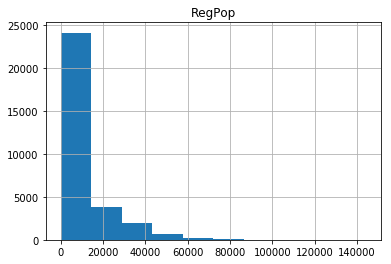

In [7]:
dfc_filter.hist(column='RegPop')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0xa1fa40c18>]],
      dtype=object)

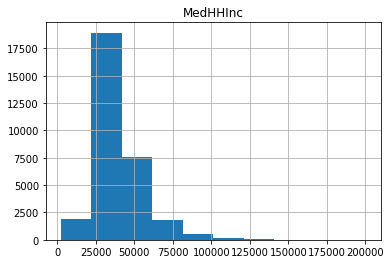

In [8]:
dfc_filter.hist(column='MedHHInc')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0xa1fa40b38>]],
      dtype=object)

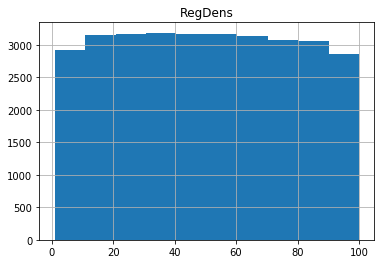

In [9]:
dfc_filter.hist(column = 'RegDens')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0xa1e1db160>]],
      dtype=object)

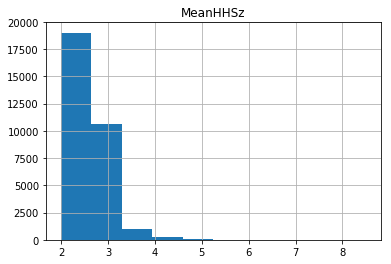

In [10]:
dfc_filter.hist(column='MeanHHSz')

* ¿Qué nos están diciendo estos gráficos sobre los datos?
* ¿Aprecias normalidad de los datos? Genera un histograma con cada variable que consideres y revisa si ¿Tiene forma de campana?

Excepto la Media, el resto representa una ligera forma de campana en los histogramas. Cabe destacar RegDens con una varianza muy elevada si se considera como distribución normal.

También puedes revisar la relación que existe entre las variables, la forma mas sencilla es mediante un gráfico de dispersión o calculando el coeficiente de correlación para revisar las relaciones lineales.

In [11]:
dfc_filter.corr()

,Numrow,LocX,LocY,RegDens,RegPop,MedHHInc,MeanHHSz
Numrow,1.000000,-0.888357,-0.043701,-0.279940,0.002020,-0.111858,0.143020
LocX,-0.888357,1.000000,-0.116894,0.254617,-0.015625,0.067608,-0.184683
LocY,-0.043701,-0.116894,1.000000,-0.161722,-0.180388,0.121010,-0.074380
RegDens,-0.279940,0.254617,-0.161722,1.000000,0.623130,0.367567,0.087272
RegPop,0.002020,-0.015625,-0.180388,0.623130,1.000000,0.202925,0.108856
MedHHInc,-0.111858,0.067608,0.121010,0.367567,0.202925,1.000000,0.154244
MeanHHSz,0.143020,-0.184683,-0.074380,0.087272,0.108856,0.154244,1.000000


#### Algunos apuntes sobre el coeficiente de correlación
El [coeficiente de correlación ](https://es.wikipedia.org/wiki/Coeficiente_de_correlaci%C3%B3n_de_Pearson) es una medida del grado de *dependencia lineal* entre dos variables. El [coeficiente de correlación](https://es.wikipedia.org/wiki/Coeficiente_de_correlaci%C3%B3n_de_Pearson) oscila entre -1 y 1. Un valor de 1 significa que una [ecuación lineal](https://es.wikipedia.org/wiki/Ecuaci%C3%B3n_de_primer_grado) describe la relación entre las dos variables a la perfección, con todos los puntos de datos cayendo sobre una línea recta de pendiente positiva. Un valor de -1 implica que todos los puntos de datos se encuentran en una línea con pendiente negativa. Un valor de 0 implica que no existe una correlación lineal entre las variables. Lo podemos calcular con el método `corr`.

In [12]:
# coeficiente de correlación
dfc_filter.corr()

,Numrow,LocX,LocY,RegDens,RegPop,MedHHInc,MeanHHSz
Numrow,1.000000,-0.888357,-0.043701,-0.279940,0.002020,-0.111858,0.143020
LocX,-0.888357,1.000000,-0.116894,0.254617,-0.015625,0.067608,-0.184683
LocY,-0.043701,-0.116894,1.000000,-0.161722,-0.180388,0.121010,-0.074380
RegDens,-0.279940,0.254617,-0.161722,1.000000,0.623130,0.367567,0.087272
RegPop,0.002020,-0.015625,-0.180388,0.623130,1.000000,0.202925,0.108856
MedHHInc,-0.111858,0.067608,0.121010,0.367567,0.202925,1.000000,0.154244
MeanHHSz,0.143020,-0.184683,-0.074380,0.087272,0.108856,0.154244,1.000000


#### Recuerda también que correlación no implica causalidad.
Todo esto de la mala interpretación de la correlación también se encuentra, y en demasiadas ocasiones, en estudios científicos supuestamente serios. No son pocos los estudios que al encontrar una cierta relación entre dos variables presentes en los sujetos estudiados se tiran a la piscina afirmando que por tanto una de ellas es la causa de la otra, cuando en realidad en dichos estudios no hay ninguna evidencia de que esto sea verdad (simplemente hay correlación).

Echa un vistazo a este link y sorprendete con las "Spurious correlations"  http://tylervigen.com/spurious-correlations

<img src="correlacion.png" style="height: 150px">

## Transformación de variables

Una herramienta muy interesante a utilizar en aquellas variables que no cumplan con los criterios de normalidad es aplicar alguna transformación sobre las mismas, en particular el logaritmo funciona muy bien, y después de aplicarla confirma si los datos transformados se comportan como una normal.

Las ventajas de aplicar una transformación cuando la distribución de la variable no es normal son las siguientes:

* Que el efecto de posibles outliers sea menor.
* En algunos casos podría inducir normalidad, condición no necesaria, pero deseable.
* Que los rangos de las variables sean más comparables

<img src="logaritmo.png" style="height: 200px">

## Tratamiento de los datos, preprocessing

Respecto al tratamiento de datos, se llevarán a cabo las siguientes tareas:

* Imputación de missings.- la única variable que contiene valores missings es RegDens. Se predecirán sus valores a partir del resto de explicativas.

* Tratamiento de outliers.- se podrían filtras aquellas observaciones atípicas respecto de cada una de las variables. Hay que tener en cuenta que esto implicaría la pérdida de algunas regiones. 

* Alternativamente (para no perder registros) o de forma adicional, se puede aplicar una transformación a las variables con las ventajas ya mencionadas

In [13]:
dfc[['RegDens']] = dfc[['RegDens']].fillna(dfc['RegDens'].mean())

In [14]:
dfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33178 entries, 0 to 33177
Data columns (total 8 columns):
Numrow      33178 non-null int64
ID          33178 non-null object
LocX        33178 non-null float64
LocY        33178 non-null float64
RegDens     33178 non-null float64
RegPop      33178 non-null float64
MedHHInc    33178 non-null float64
MeanHHSz    33178 non-null float64
dtypes: float64(6), int64(1), object(1)
memory usage: 2.0+ MB


In [15]:
dfc_out = dfc [['LocX', 'LocY', 'RegDens','RegPop', 'MedHHInc', 'MeanHHSz']]

In [16]:
dfc_out.head()

,LocX,LocY,RegDens,RegPop,MedHHInc,MeanHHSz
0,-66.749472,18.180103,70.0,19143.0,9888.0,3.24
1,-67.180247,18.363285,83.0,42042.0,11384.0,3.10
2,-67.134224,18.448619,86.0,55592.0,10748.0,2.84
3,-67.136995,18.498987,83.0,3844.0,31199.0,3.00
4,-66.958807,18.182151,65.0,6449.0,9243.0,3.20


In [17]:
dfc_out.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33178 entries, 0 to 33177
Data columns (total 6 columns):
LocX        33178 non-null float64
LocY        33178 non-null float64
RegDens     33178 non-null float64
RegPop      33178 non-null float64
MedHHInc    33178 non-null float64
MeanHHSz    33178 non-null float64
dtypes: float64(6)
memory usage: 1.5 MB


In [18]:
from scipy import stats
import numpy as np
z = np.abs(stats.zscore(dfc_out))
print(z)

[[1.61473959e+00 3.85315713e+00 6.86111934e-01 8.12572463e-01
  1.62346446e+00 1.24096426e+00]
 [1.58615553e+00 3.81897702e+00 1.14352026e+00 2.57694350e+00
  1.53782642e+00 1.00596163e+00]
 [1.58920939e+00 3.80305447e+00 1.24907602e+00 3.62097283e+00
  1.57423404e+00 5.69528182e-01]
 ...
 [2.67954600e+00 3.18051390e+00 1.70648544e+00 6.58776911e-01
  3.09174993e-02 6.05484969e-01]
 [2.73412369e+00 3.11785590e+00 2.50006277e-16 6.62398267e-01
  2.18949984e+00 4.19766800e+00]
 [2.75141022e+00 3.13204857e+00 1.74167069e+00 6.32965116e-01
  2.86114277e-01 1.18693797e-01]]


In [19]:
#se crea la variable donde se guardan los utliers detectados
dfc_outlier = dfc_out[(z < 3).all(axis=1)]

In [20]:
dfc_outlier.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30463 entries, 130 to 32925
Data columns (total 6 columns):
LocX        30463 non-null float64
LocY        30463 non-null float64
RegDens     30463 non-null float64
RegPop      30463 non-null float64
MedHHInc    30463 non-null float64
MeanHHSz    30463 non-null float64
dtypes: float64(6)
memory usage: 1.6 MB


In [21]:
dfc_outlier.head()

,LocX,LocY,RegDens,RegPop,MedHHInc,MeanHHSz
130,-72.620290,42.070610,83.0,16475.0,45735.0,2.25
131,-72.503237,42.377651,77.0,36776.0,42567.0,2.46
132,-72.104432,42.412094,59.0,5079.0,50395.0,2.69
133,-72.411005,42.278424,68.0,12997.0,52425.0,2.65
134,-72.948288,42.174313,28.0,1234.0,52663.0,2.68


In [22]:
# >>> df = pd.concat([dfc_out, dfc_outlier])
# >>> df = df.reset_index(drop=True)

In [23]:
# df_gpby = df.groupby(list(df.columns))
# idx = [x[0] for x in df_gpby.groups.values() if len(x) == 1]
# df.reindex(idx)

## Imputación de valores ausentes
En los pasos anteriores hemos identificado los outliers y les hemos asignado a un valor nulo.

Ahora en este paso lo que vamos a hacer es darles un valor a los outliers para tener un dataset sin valores nulos y completar también si hay datos missing. Utiliza la técnica que consideres mas adecuada.

Recuerda que una opción es predecir los valores missing a partir de otras variables explicativas a través de una regresión.

Para mostrarte como realizar una regresión simple te incluyo un ejemplo a continuación.
En primer lugar generamos unos datos "casi aleatorios" que nos sirvan de ejemplo. Se trata de ajustar una línea que siga el modelo siguiente:
$$
y = ax + b
$$
donde $a$ es conocida como *slope* o *pendiente*, y $b$ es conocida como *intercept* o *constante*.

Consideramos los siguientes datos, que mostramos con gráfico de dispersión y que consiste en un modelo con pendiente 2 y constante -5:

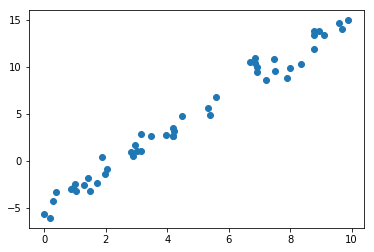

In [24]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)
plt.scatter(x, y);

Podemos utilizar el estimador Scikit-Learn's LinearRegression para ajustar los datos y construir la recta que mejor se ajusta:

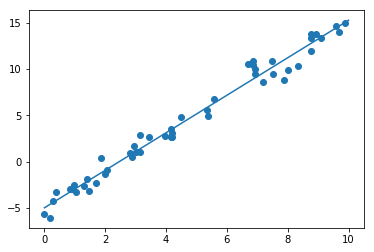

In [25]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

Y ya lo tenemos, la pendiente y la constante del modelo están en los parámetros fit, que como sabemos aparecen en Scikit-Learn marcados con un guión bajo.
Los parámetros relevantes son ``coef_`` y ``intercept_``. Y podemos utilizar cualquier nuevo dato de x para estimar y.

In [26]:
#Diferencia para conocer el numero de outliers eliminadso por Z-Score
diff = len(dfc_outlier)-len(dfc_out)
diff

-2715

In [27]:

list = dfc_out.mean()

In [28]:
#Datafarame que se usara para sustituir la cantidad de outliers por el vaor medio de cada variable
mean_outlier = pd.DataFrame(columns =  ['LocX', 'LocY', 'RegDens','RegPop', 'MedHHInc', 'MeanHHSz'])

In [29]:
i = 0
while i < abs(diff):
    mean_outlier = mean_outlier.append([list])
    i+=1

In [30]:
dfc_final = pd.concat([dfc_outlier, mean_outlier], ignore_index=True)

In [31]:
dfc_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33178 entries, 0 to 33177
Data columns (total 6 columns):
LocX        33178 non-null float64
LocY        33178 non-null float64
RegDens     33178 non-null float64
RegPop      33178 non-null float64
MedHHInc    33178 non-null float64
MeanHHSz    33178 non-null float64
dtypes: float64(6)
memory usage: 1.5 MB


In [32]:
dfc_final = dfc_final.values

* ¿Consideras que dispones ahora de un dataset mas adecuado para hacer un clustering? ¿Por qué?

En este caso se procede a empezar con el clustring tras identificar los outliers que pueden provocar problemas en los algoritmos que se usan a continuación

# Clustering jerárquico aglomerativo y kmeans

En esta parte queremos aplicar el método K-means ( y en particular kmeans ++) al dataset anterior con el objetivo de determinar los clusters mas adecuados para abrir tiendas e incluso la tipología de tiendas que consideremos mas apropiada para los diferentes clusters.

* Aunque existen otras técnicas, se recomienda aplicar un método de clusterización jerárquico aglomerativo en una primera etapa y a través del dendrograma seleccionar el número de clusters adecuado

* Posteriormente aplicamos kmeans sobre los clusters estimados por el metodo jerárquico.

<img src="dendrograma.png" width="50%">

Para que sea mas productivo, la recomendación es realizarlo de la siguiente forma:

* Primero seleccionar una submuestra de 100-200 registros para visualizar adecuadamente el dendrograma y de ahí extraer el número de clusters.
* Aplicar kmeans al número de clusters elegido previamente.

Si el resultado no fuese adecuado ejecutar kmeans variando el número de clusters de acuerdo a la información proporcionada por el dendrograma.

In [33]:
from sklearn.cluster import KMeans

In [34]:
# creamos objeto kmeans
kmeans = KMeans(n_clusters=6,init='k-means++')
# hacemos el ajuste del objeto kmeans a los datos
kmeans.fit(dfc_final)
# mostramos la localización de los clusters en el objeto kmeans
print(kmeans.cluster_centers_)
# salvamos los nuevos clusters para graficarlos
y_km = kmeans.fit_predict(dfc_final)

[[-9.20311286e+01  3.79610240e+01  3.47162864e+01  2.26878507e+03
   2.55077292e+04  2.49114298e+00]
 [-8.82273632e+01  4.00706265e+01  5.54139667e+01  4.88258910e+03
   5.08176848e+04  2.64660902e+00]
 [-9.09231462e+01  3.68712768e+01  7.94878274e+01  2.76792974e+04
   3.51794465e+04  2.53479198e+00]
 [-8.58003149e+01  3.95252329e+01  7.28974855e+01  9.76067698e+03
   7.31674500e+04  2.71184397e+00]
 [-9.25170649e+01  3.83707839e+01  8.51280702e+01  3.02720187e+04
   5.79315456e+04  2.63615789e+00]
 [-9.04642905e+01  3.94756519e+01  4.22836636e+01  4.45997258e+03
   3.71757827e+04  2.55044896e+00]]


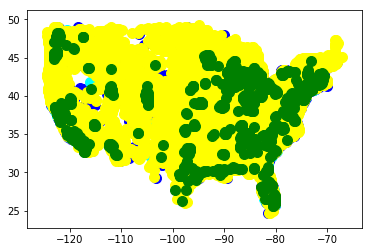

In [35]:
#plt.scatter(dfc_final[y_km ==0,0], dfc_final[y_km == 0,1], s=100, c='red')
#plt.scatter(dfc_final[y_km ==1,0], dfc_final[y_km == 1,1], s=100, c='black')
plt.scatter(dfc_final[y_km ==2,0], dfc_final[y_km == 2,1], s=100, c='blue')
plt.scatter(dfc_final[y_km ==3,0], dfc_final[y_km == 3,1], s=100, c='cyan')
plt.scatter(dfc_final[y_km ==4,0], dfc_final[y_km == 4,1], s=100, c='yellow')
plt.scatter(dfc_final[y_km ==5,0], dfc_final[y_km == 5,1], s=100, c='green')

In [36]:
y_km.max()

5

In [37]:
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

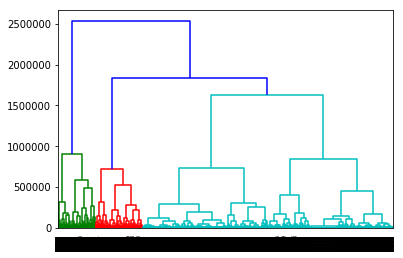

In [38]:
# creamos el dendrograma
dendrogram = sch.dendrogram(sch.linkage(dfc_final, method='ward'))
# creamos los clusters
hc = AgglomerativeClustering(n_clusters=6, affinity = 'euclidean', linkage = 'ward')
# salvamos los clusters para graficarlos
y_hc = hc.fit_predict(dfc_final)

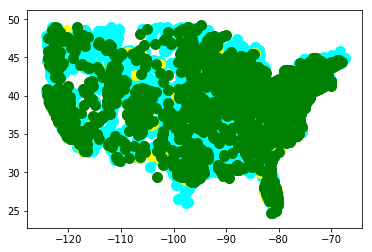

In [46]:
#plt.scatter(dfc_final[y_hc ==0,0], dfc_final[y_hc == 0,1], s=100, c='red')
#plt.scatter(dfc_final[y_hc==1,0], dfc_final[y_hc == 1,1], s=100, c='black')
#plt.scatter(dfc_final[y_hc ==2,0], dfc_final[y_hc == 2,1], s=100, c='blue')
plt.scatter(dfc_final[y_hc ==3,0], dfc_final[y_hc == 3,1], s=100, c='cyan')
plt.scatter(dfc_final[y_hc ==4,0], dfc_final[y_hc == 4,1], s=100, c='yellow')
plt.scatter(dfc_final[y_hc ==5,0], dfc_final[y_hc == 5,1], s=100, c='green')

In [40]:
y_hc

array([2, 2, 5, ..., 3, 3, 3])

In [41]:
dfc.describe()

,Numrow,LocX,LocY,RegDens,RegPop,MedHHInc,MeanHHSz
count,33178.000000,33178.000000,33178.000000,33178.000000,33178.000000,33178.000000,33178.000000
mean,16588.500000,-91.084343,38.830389,50.500016,8596.977395,38248.093857,2.500710
std,9577.807952,15.070689,5.359397,28.421424,12978.758221,17469.135891,0.595747
min,0.000000,-176.636755,17.962234,1.000000,0.000000,0.000000,0.000000
25%,8294.250000,-97.219483,35.383955,26.000000,656.000000,28903.750000,2.360000
50%,16588.500000,-88.308757,39.460478,50.500016,2515.000000,35762.000000,2.550000
75%,24882.750000,-80.380665,42.105602,75.000000,11167.500000,45229.250000,2.740000
max,33177.000000,-65.292575,71.299525,100.000000,144024.000000,200001.000000,8.490000


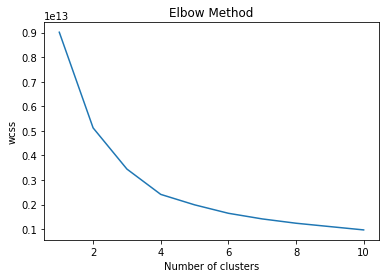

In [42]:
#Using the elbow method to find the optimum number of clusters
from sklearn.cluster import KMeans
wcss = []
for i in range(1,11):
    km=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(dfc_final)
    wcss.append(km.inertia_)
plt.plot(range(1,11),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

# ¿Y si utilizas DBSCAN?

In [43]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

Text(0,0.5,'Feature 1')

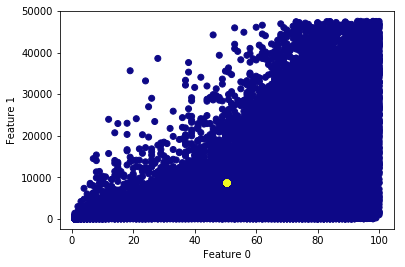

In [44]:
# clusterizamos los datos anteriores en 4 clusters
dbscan = DBSCAN(eps=1.5, min_samples = 10)
clusters = dbscan.fit_predict(dfc_final)
# graficamos las asignaciones de clusters
plt.scatter(dfc_final[:, 2], dfc_final[:, 3], c=clusters, cmap="plasma")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

# Perfiles de los clusters (profiling)

Una vez generados los clusters adecuados tenemos que analizar el pérfil de cada uno de los segmentos, utilizando las variables que tenemos disponibles.

El análisis de los pérfiles nos ayudará a establecer las conclusiones y las recomendaciones.

In [ ]:
profiles = pd.DataFrame(dfc_final, columns=['LocX', 'LocY', 'RegDens','RegPop', 'MedHHInc', 'MeanHHSz'])
profiles['Cluster'] = y_km

profiles

In [ ]:
Profiling = profiles[['RegDens','RegPop', 'MedHHInc', 'MeanHHSz', 'Cluster']]
Profiling = Profiling.groupby(['Cluster']).mean().add_suffix('_avg').reset_index()
Profiling

# Conclusiones y recomendaciones

* ¿Cuantos clusters has identificado?
* ¿Qué les caracteriza a cada uno de ellos?
* ¿Qué propuesta de tipología de tiendas propondrías?
* ¿Que otros factores tendrías en cuenta para diseñar un plan de expansión de tiendas?

Regiones con alta densidad de poblacion

Se han identificado los Clusters numero 2 y 4 con areas con alta densidad en la region - zonas muy pobladas - donde además el ingreso medio coincide con ser el más alto. Una sugerencia podria ser localizar en grandes establecimientos oportunidades o hacer aperturas de centros mas grandes y, pro tanto, es necesaria una mayor inversion. Se pueden identificar como las grandes ciudades y sus suburbios en USA, como se muestra a continuacion:

In [ ]:
plt.scatter(dfc_final[y_km ==2,0], dfc_final[y_km == 2,1], s=100, c='blue')

In [ ]:
plt.scatter(dfc_final[y_km ==4,0], dfc_final[y_km == 4,1], s=100, c='green')

Zonas rurales 

En los Clusters 1 y 3 se puede identificar las zonas mas extensas y por todo el terrotorio, con valores de densidad de poblacion mas bajos, y con rentas en niveles inferiores. Se presenta una extensa region donde la distribucion y la oferta podria ser diferente para estos potenciales clientes.|

In [ ]:
plt.scatter(dfc_final[y_km ==1,0], dfc_final[y_km == 1,1], s=100, c='green')

In [ ]:
plt.scatter(dfc_final[y_km ==3,0], dfc_final[y_km == 3,1], s=100, c='blue')

Ademas de la estrategia propuesta con los valores obtenidos, se puede correlar y extender este estudio con datos como movilidad, paro, tecnologia o economia; asumiendo que todos ellos podrian influir considerablemente a la hora de la estrategia de distrubcion basado en posibles clientes.